In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Install & Import Required Libraries



In [2]:
# Uncomment these if running in Kaggle (XGBoost & SHAP may not be pre-installed)
# !pip install xgboost shap
# !pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1
# !pip install numpy>=2.0


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
import joblib
import os
import shap
import warnings
warnings.filterwarnings('ignore')


e:\Program Files\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Load and Clean the Dataset

In [3]:
# Load dataset
df = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Remove spaces in column names (if any)
df.columns = df.columns.str.strip()

# Convert TotalCharges to numeric, coerce errors
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows with missing TotalCharges
df.dropna(inplace=True)

# Reset index
df.reset_index(drop=True, inplace=True)

# Drop customerID
df.drop('customerID', axis=1, inplace=True)

# copy of the original data
df_original = df.copy()

# 3. Encode Categorical Variables

In [4]:
# Binary encoding for target
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Identify categorical columns
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Label encode binary categories, One-hot encode multi-category columns
label_cols = [col for col in cat_cols if df[col].nunique() == 2]
onehot_cols = [col for col in cat_cols if df[col].nunique() > 2]

# Label Encoding
le = LabelEncoder()
for col in label_cols:
    df[col] = le.fit_transform(df[col])

# One-hot Encoding
df = pd.get_dummies(df, columns=onehot_cols)

# Save the column names used during training
os.makedirs("models_train_all_features", exist_ok=True)

# ✅ Save column names to the same folder
joblib.dump(df.columns.tolist(), "models_train_all_features/columns.pkl")

# Scale numeric features
scaler = StandardScaler()
df[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(df[['tenure', 'MonthlyCharges', 'TotalCharges']])

# 4. Exploratory Data Analysis (EDA)

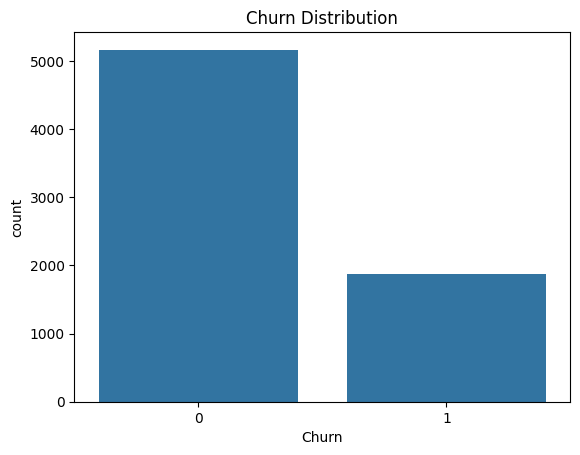

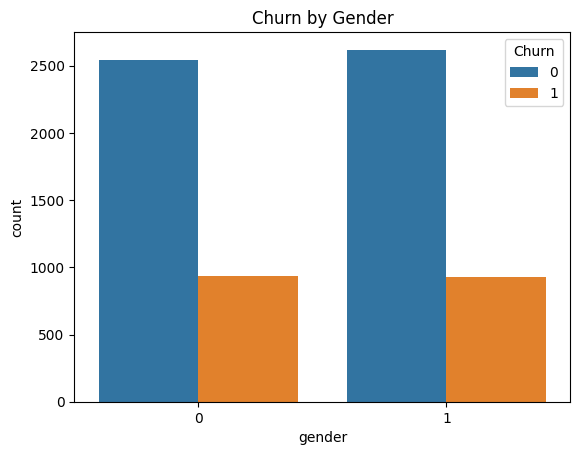

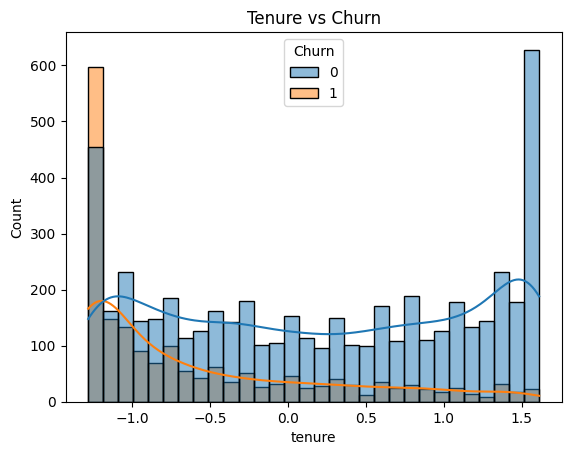

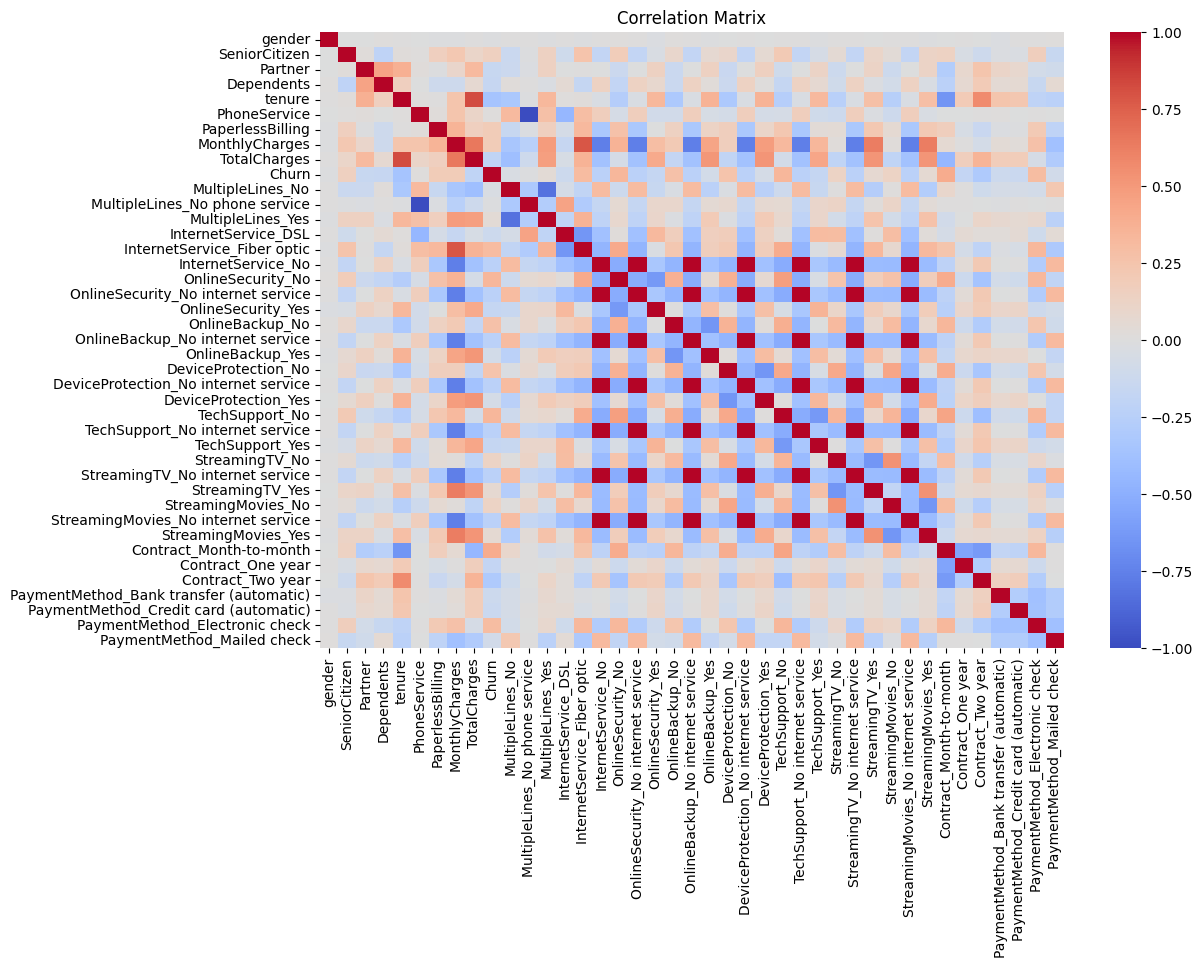

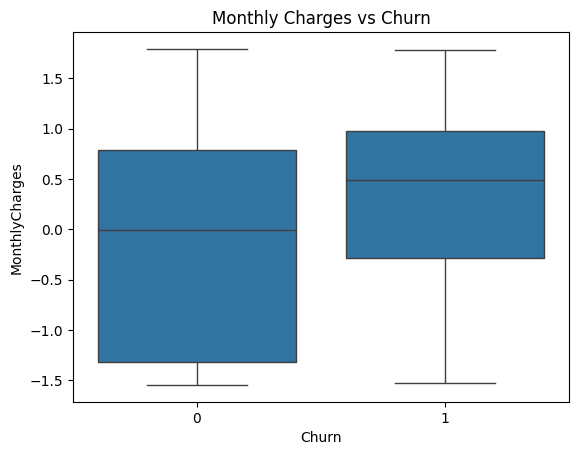

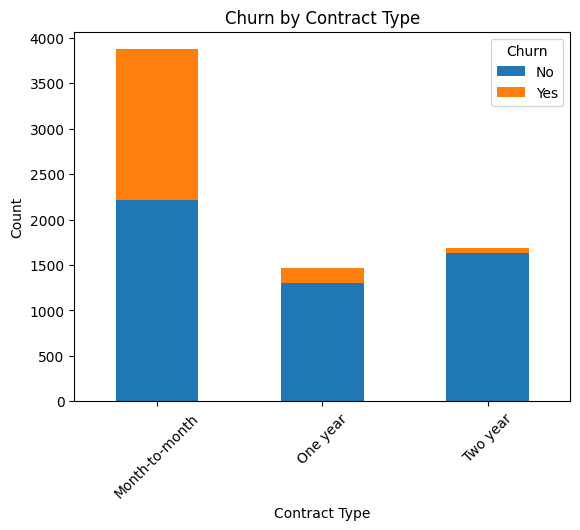

In [5]:
# Churn distribution
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

# Gender vs Churn
sns.countplot(x='gender', hue='Churn', data=df)
plt.title("Churn by Gender")
plt.show()

# Tenure vs Churn
sns.histplot(data=df, x='tenure', hue='Churn', bins=30, kde=True)
plt.title("Tenure vs Churn")
plt.show()

# Heatmap of correlations
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()

# Charges Distribution by Churn
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Monthly Charges vs Churn')
plt.show()

# Churn by Senior Citizen & Contract Type (Stacked)
pd.crosstab(df_original['Contract'], df_original['Churn']).plot(kind='bar', stacked=True)
plt.title('Churn by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# 5. Model Training & Evaluation

In [6]:
# Define features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    test_size=0.2, random_state=42)

os.makedirs("data", exist_ok=True)

# ✅ Save test sets in the 'data' folder
X_test.to_csv("data/X_test.csv", index=False)
y_test.to_csv("data/y_test.csv", index=False)

# Apply SMOTE only on training
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Train and evaluate
trained_models = {}
y_preds = {}
y_probas = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model
    y_preds[name] = model.predict(X_test)
    y_probas[name] = model.predict_proba(X_test)[:, 1]
    print(f"=== {name} Evaluation ===")
    print("Accuracy:", accuracy_score(y_test, y_preds[name]))
    print("Precision:", precision_score(y_test, y_preds[name]))
    print("Recall:", recall_score(y_test, y_preds[name]))
    print("F1 Score:", f1_score(y_test, y_preds[name]))
    print("AUC:", roc_auc_score(y_test, y_probas[name]))
    print()
    print("Classification Report:\n", classification_report(y_test, y_preds[name]))
    print()


=== Logistic Regression Evaluation ===
Accuracy: 0.8045486851457001
Precision: 0.649546827794562
Recall: 0.5748663101604278
F1 Score: 0.6099290780141843
AUC: 0.8358772797158993

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407


=== Random Forest Evaluation ===
Accuracy: 0.7938877043354655
Precision: 0.6372549019607843
Recall: 0.5213903743315508
F1 Score: 0.5735294117647057
AUC: 0.817378126116239

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.64      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.74      0.71      0.72      1407
we

# 6. SHAP Feature Importance (for XGBoost)

SHAP Summary Plot (Bar)


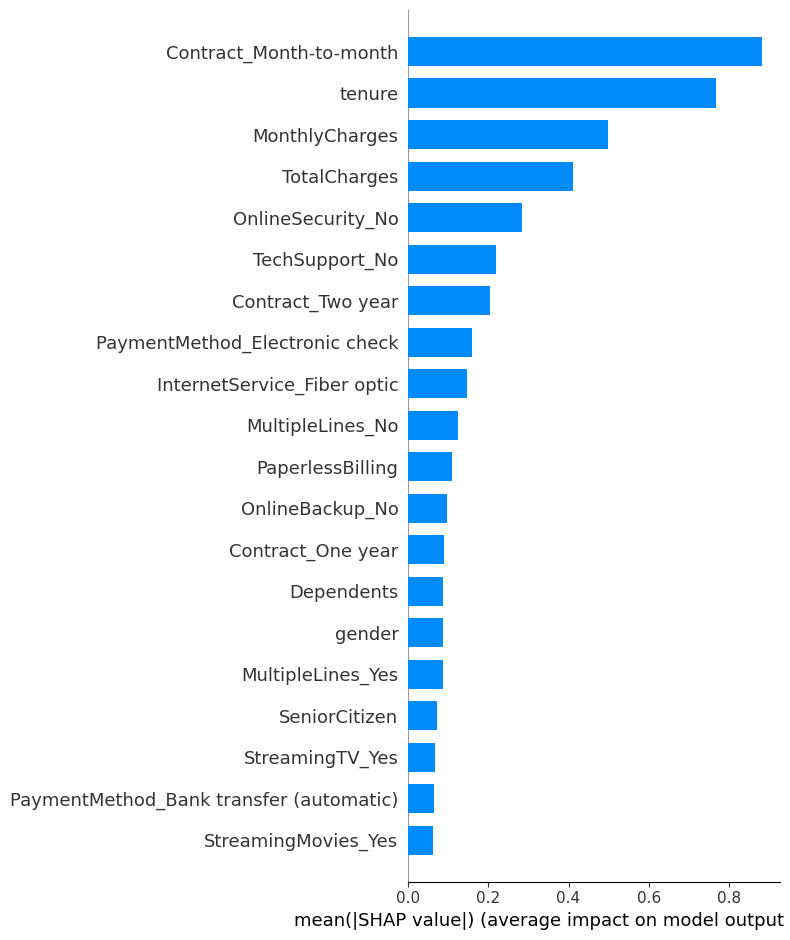

SHAP Summary Plot


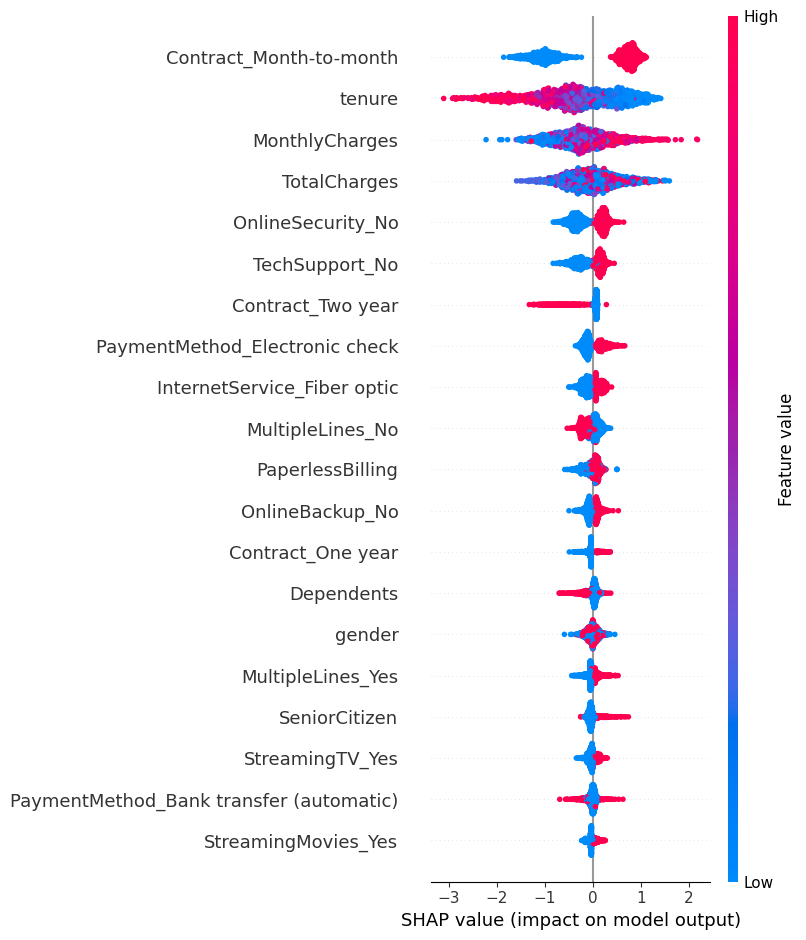

In [7]:
explainer = shap.TreeExplainer(trained_models['XGBoost'])
shap_values = explainer.shap_values(X_test)
print("SHAP Summary Plot (Bar)")
shap.summary_plot(shap_values, X_test, plot_type="bar")
print("SHAP Summary Plot")
shap.summary_plot(shap_values, X_test)

# 7. ROC Curve for all models

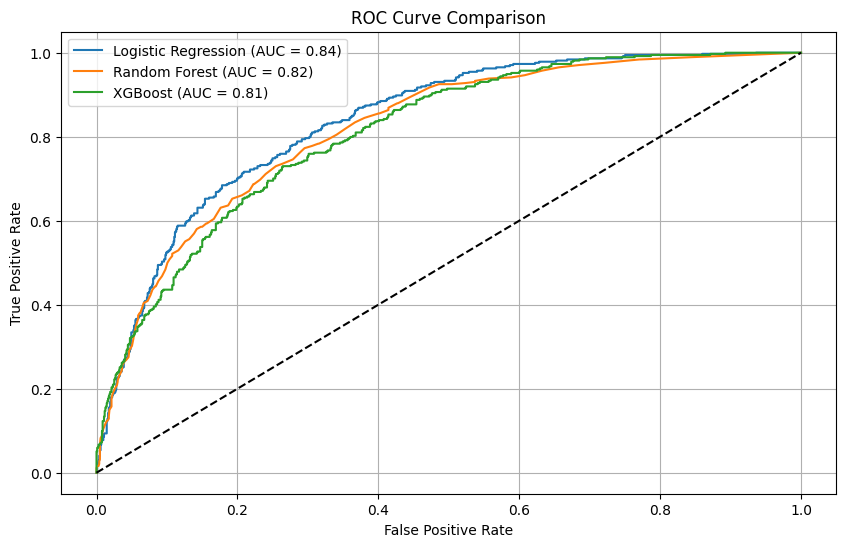

In [8]:
plt.figure(figsize=(10, 6))
for name in trained_models:
    fpr, tpr, _ = roc_curve(y_test, y_probas[name])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_probas[name]):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()


# 8. Feature Importance Visualizations

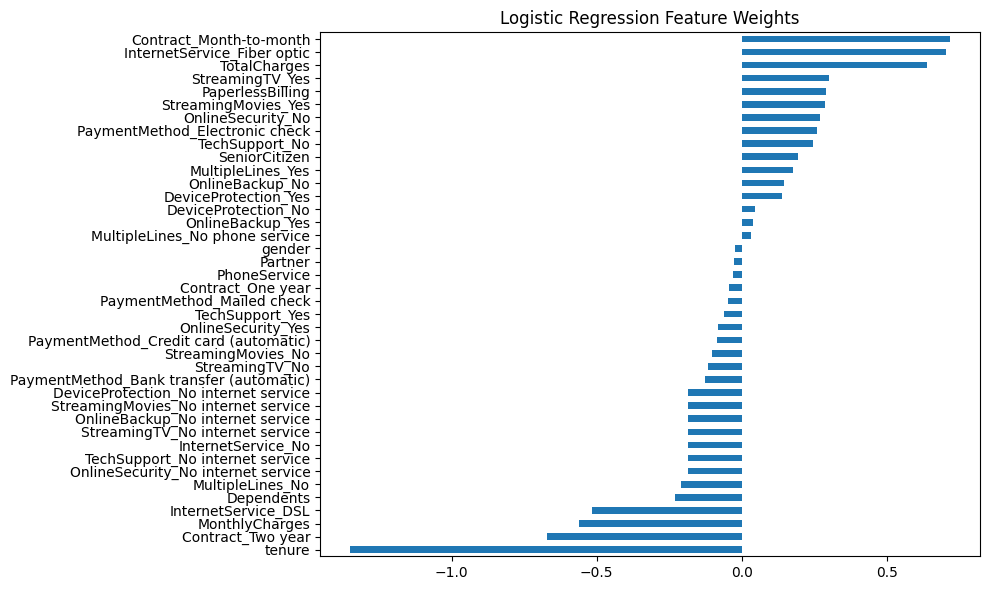

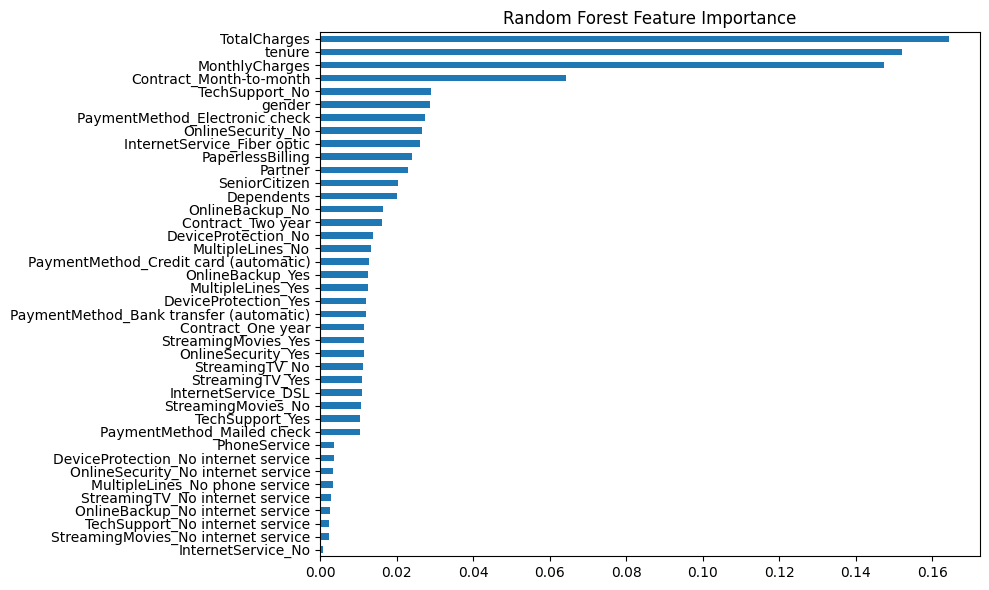

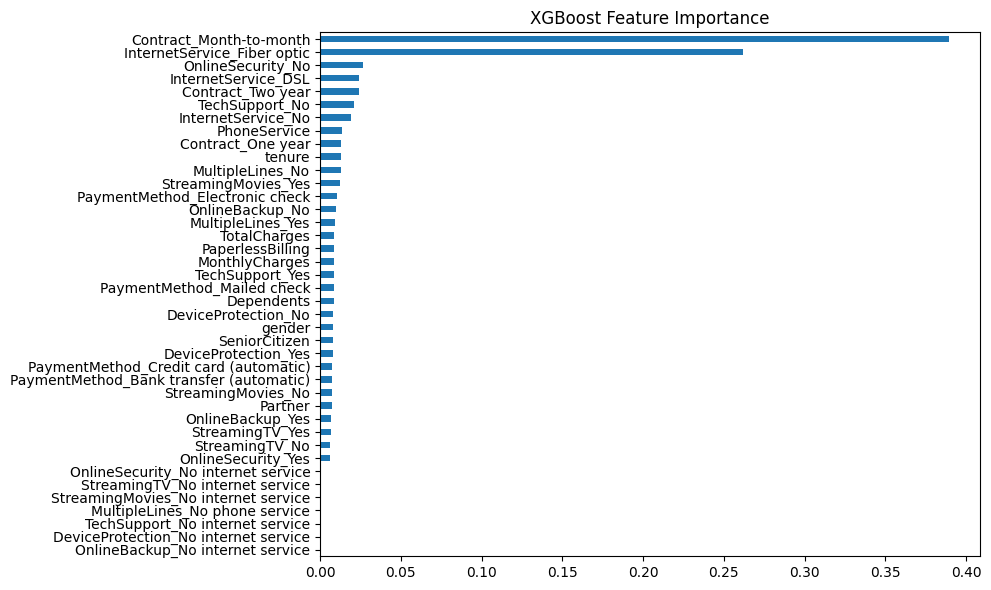

In [9]:
# Logistic Regression Coefficients
lr = trained_models['Logistic Regression']
lr_importance = pd.Series(lr.coef_[0], index=X.columns).sort_values()

plt.figure(figsize=(10, 6))
lr_importance.plot(kind='barh')
plt.title("Logistic Regression Feature Weights")
plt.tight_layout()
plt.show()

# Random Forest Feature Importance
rf = trained_models['Random Forest']
rf_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values()

plt.figure(figsize=(10, 6))
rf_importance.plot(kind='barh')
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

# XGBoost Feature Importance
xgb = trained_models['XGBoost']
xgb_importance = pd.Series(xgb.feature_importances_, index=X.columns).sort_values()

plt.figure(figsize=(10, 6))
xgb_importance.plot(kind='barh')
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

# 9. Confusion Matrices

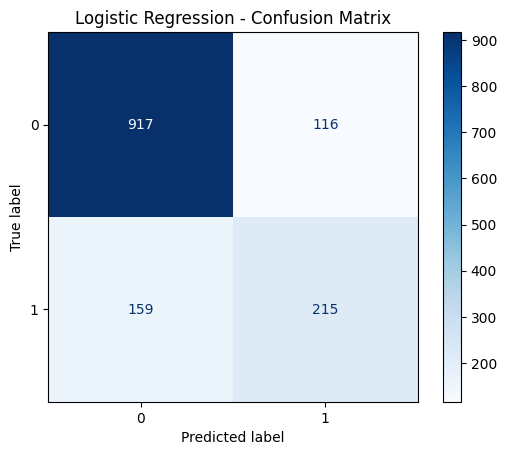

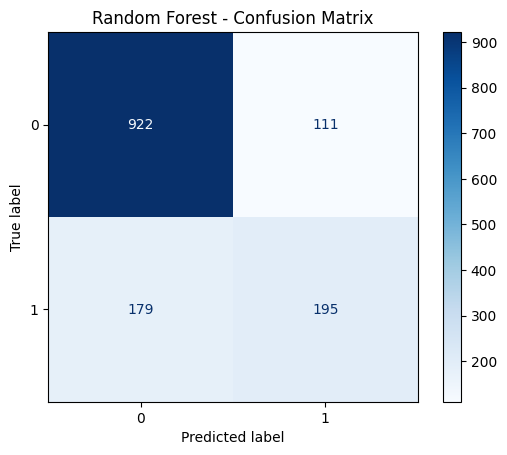

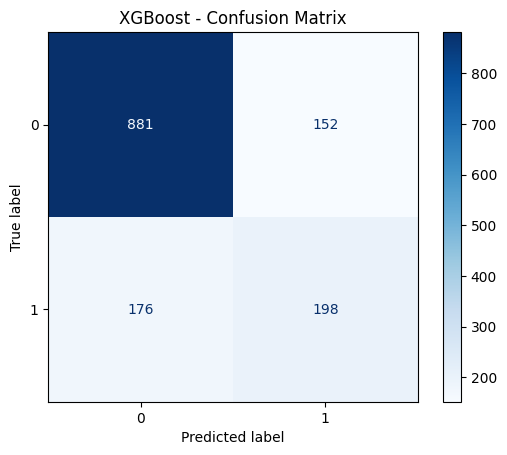

In [10]:
for name, model in trained_models.items():
    cm = confusion_matrix(y_test, y_preds[name])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

# 10. Cross-validation using F1-score

In [11]:
print("\nCross-Validation Results (5-Fold Stratified, F1-score):\n")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=skf, scoring='f1')
    print(f"{name}: Avg F1-score = {scores.mean():.4f}")


Cross-Validation Results (5-Fold Stratified, F1-score):

Logistic Regression: Avg F1-score = 0.6002
Random Forest: Avg F1-score = 0.5560
XGBoost: Avg F1-score = 0.5609


# 11. Test Set Performance Summary

In [12]:
summary = []

for name in trained_models:
    y_pred = y_preds[name]
    y_proba = y_probas[name]
    summary.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_proba)
    })

results_df = pd.DataFrame(summary)
print("Final Model Performance Summary:\n")
print(results_df)

Final Model Performance Summary:

                 Model  Accuracy  Precision    Recall  F1 Score       AUC
0  Logistic Regression  0.804549   0.649547  0.574866  0.609929  0.835877
1        Random Forest  0.793888   0.637255  0.521390  0.573529  0.817378
2              XGBoost  0.766880   0.565714  0.529412  0.546961  0.808840


# To Download saved model files

In [13]:
import joblib
import os

# ✅ Create the folder if it doesn't exist
os.makedirs("models_train_all_features", exist_ok=True)

# ✅ Save each model to the new folder
joblib.dump(trained_models['Logistic Regression'], 'models_train_all_features/logistic.pkl')
joblib.dump(trained_models['Random Forest'], 'models_train_all_features/rf.pkl')
joblib.dump(trained_models['XGBoost'], 'models_train_all_features/xgb.pkl')


['models_train_all_features/xgb.pkl']

# To Check Top Features Across All Models

In [14]:
# Load models
lr = joblib.load("models_train_all_features/logistic.pkl")
rf = joblib.load("models_train_all_features/rf.pkl")
xgb = joblib.load("models_train_all_features/xgb.pkl")

# Load column names
columns = joblib.load("models_train_all_features/columns.pkl")

print("Model expects:", len(lr.coef_[0]), "features")
print("columns.pkl has:", len(columns), "columns")

model_feature_count = len(lr.coef_[0])
column_count = len(columns)

if model_feature_count != column_count:
    print(f"⚠️ Mismatch: Model has {model_feature_count}, but columns.pkl has {column_count}")

if "Churn" in columns:
    columns.remove("Churn")
    print("Removed 'Churn' from columns.")

joblib.dump(columns, "models_train_all_features/columns.pkl")
print("✅ columns.pkl updated and saved successfully with 40 correct features.")

# Get importances
lr_importance = pd.Series(np.abs(lr.coef_[0]), index=columns)
rf_importance = pd.Series(rf.feature_importances_, index=columns)
xgb_importance = pd.Series(xgb.feature_importances_, index=columns)  # ✅ fixed here

# Combine into one DataFrame
importance_df = pd.DataFrame({
    'Logistic': lr_importance,
    'RandomForest': rf_importance,
    'XGBoost': xgb_importance
})

# Normalize (optional)
importance_df = importance_df / importance_df.max()

# Average score
importance_df['Average'] = importance_df.mean(axis=1)

# Sort and display
top_features = importance_df.sort_values(by='Average', ascending=False)
print("Top 10 important features across all models:")
print(top_features.head(10))


Model expects: 40 features
columns.pkl has: 41 columns
⚠️ Mismatch: Model has 40, but columns.pkl has 41
Removed 'Churn' from columns.
✅ columns.pkl updated and saved successfully with 40 correct features.
Top 10 important features across all models:
                                Logistic  RandomForest   XGBoost   Average
tenure                          1.000000      0.926223  0.033496  0.653240
Contract_Month-to-month         0.531611      0.391998  1.000000  0.641203
TotalCharges                    0.473807      1.000000  0.022995  0.498934
InternetService_Fiber optic     0.520288      0.159668  0.672570  0.450842
MonthlyCharges                  0.415512      0.896699  0.022654  0.444955
Contract_Two year               0.497796      0.098782  0.061380  0.219319
InternetService_DSL             0.383271      0.066666  0.061778  0.170572
OnlineSecurity_No               0.198825      0.162365  0.068924  0.143371
TechSupport_No                  0.183039      0.176259  0.054901  0.138066